# Notebook asociated to the v2 latex document

### We compute the U_+ fields on the CPU

Set the relevant parameters and variables

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2.5         
N = 128 
tau_sim = 1.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.68        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.2 * g**2 * mu         
uv = 10.0       


nevents = 1

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su

Using Numba
Using SU(3)
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Define the simulation routine

In [3]:
from tqdm import tqdm 

# Simulation routine
def simulate():
    
    # Dictionary to store the results
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N/L*hbarc
    DT = 1.0/DTS 
    maxt = int(tau_sim/a*DTS)
    
    # We create the object Glasma Simulation
    s = core.Simulation(N, DT, g)
    
    # We intialize the Glasma fields
    va = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create objects to store the relevant gauge links
    ux = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    ut = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    up = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    up_reorder = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    # ux_reorder = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    # ut_reorder = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We set them to unit
    for xplus in range(maxt//DTS):
        for y in range(N):
            for z in range(N):
                ux[xplus, y, z] = su.unit()
                ut[xplus, y, z] = su.unit()
                up[xplus, y, z] = su.unit()
    
    # We create objects to store the fields at every time step
    ux_sim = np.zeros((maxt, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    aeta_sim = np.zeros((maxt, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We start the simulation
    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            
            # Evolve the Glasma fields
            core.evolve_leapfrog(s)
            
            u1 = s.u1.copy()
            ux_sim[t] = u1[:, 0, :].reshape(N, N, su.GROUP_ELEMENTS)
            
            aeta1 = s.aeta1.copy()
            aeta_sim[t] = aeta1.reshape(N, N, su.GROUP_ELEMENTS)
            
            # When t/a is an integer we compute the LC coordinate links
            if t%DTS == 0:
                xplus = t//DTS
                
                for y in range(N):
                    for z in range(N):
                        
                        if -xplus<(z-N/2)<xplus:
                            
                            # We extract the temporal index
                            tau = round(DTS*np.sqrt((xplus)**2-(z-N/2)**2))
                            
                            # We compute the x link
                            ux[xplus, y, z] = su.dagger(ux_sim[tau, xplus, y])
                            
                            # We compute the t link
                            aeta_dag = su.dagger(aeta_sim[tau, xplus, y])
                            aeta_fact = su.mul_s(aeta_dag, -(z-N/2)/((xplus)**2-(z-N/2)**2))
                            ut[xplus, y, z] = su.mexp(aeta_fact)
                            
                            # We compute the plus link
                            up[xplus, y, z] = su.mul(ut[xplus, y, z], ux[xplus, y, z])
                            
                        if z-N/2 >= 0:
                            up_reorder[xplus, y, z-N//2] = up[xplus, y, z]
                            # ux_reorder[xplus, y, z-N//2] = ux[xplus, y, z]
                            # ut_reorder[xplus, y, z-N//2] = ut[xplus, y, z]
                        else:
                            up_reorder[xplus, y, N//2+z] = up[xplus, y, z]
                            # ux_reorder[xplus, y, N//2+z] = ux[xplus, y, z]
                            # ut_reorder[xplus, y, N//2+z] = ut[xplus, y, z]
                            
                        
                            
                        
                            
            pbar.update(1)
            
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    # We reshape the transverse component as an N*N array to input in Meijian's code
    up_jetsim = up_reorder.reshape(maxt//DTS, N*N, su.GROUP_ELEMENTS)
    # ux_jetsim = ux_reorder.reshape(maxt//DTS, N*N, su.GROUP_ELEMENTS)
    # ut_jetsim = ut_reorder.reshape(maxt//DTS, N*N, su.GROUP_ELEMENTS)
        
    # Write the results to the dictionary
    output["ux"] = ux
    output["ut"] = ut
    output["up"] = up
    output['up_out'] = up_jetsim
    # output['ux_out'] = ux_jetsim
    # output['ut_out'] = ut_jetsim
    
    return output

Perform the simulation

In [4]:
import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    output = simulate()
    ux = output['ux']
    ut = output['ut']
    up = output['up']
    up_out = output['up_out']
    # ux_out = output['ux_out']
    # ut_out = output['ut_out']
    
    # np.save(os.path.join('v2_fields', 'ux_temp', 'result_%i.npy' %n), ux_out)
    # np.save(os.path.join('v2_fields', 'ut_temp', 'result_%i.npy' %n), ut_out)
    # np.save(os.path.join('simulations', 'up_temp', 'result_%i.npy' %n), up_out)
    

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Kernel xi: 0 d:  0 did not reach goal. check:  0.0016775517599554389
Kernel xi: 0 d:  1 did not reach goal. check:  0.007389037957913885
Kernel xi: 1 d:  0 did not reach goal. check:  0.0017042704250849004
Kernel xi: 1 d:  1 did not reach goal. check:  0.010006565075665925
Kernel xi: 2 d:  0 did not reach goal. check:  0.0016577581603084237
Kernel xi: 2 d:  1 did not reach goal. check:  0.010939868395186955
Kernel xi: 3 d:  0 did not reach goal. check:  0.001105431773965947
Kernel xi: 3 d:  1 did not reach goal. check:  0.007820826476223074
Kernel xi: 4 d:  0 did not reach goal. check:  0.0007166387918657427
Kernel xi: 4 d:  1 did not reach goal. check:  0.0035533173717693604
Kernel xi: 5 d:  0 did not reach goal. check:  0.0009253140706591337
Kernel xi: 5 d:  1 did not reach goal. check:  0.0023516122327470893
Kernel xi: 6 d:  0 did not reach goal. check:  0.0009146898587463824
Kernel xi: 6 d:  1 did not reach goal. check:  0.0038613381450847725
Kernel xi: 7 d:  0 did not reach goal. 

100%|██████████| 512/512 [00:11<00:00, 43.82it/s]


We plot the results

In [5]:
# Extract the color components

ux_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, ux)
ut_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, ut)
up_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, up)

FileNotFoundError: [Errno 2] No such file or directory: 'v2_fields/temporal_gauge_fields.png'

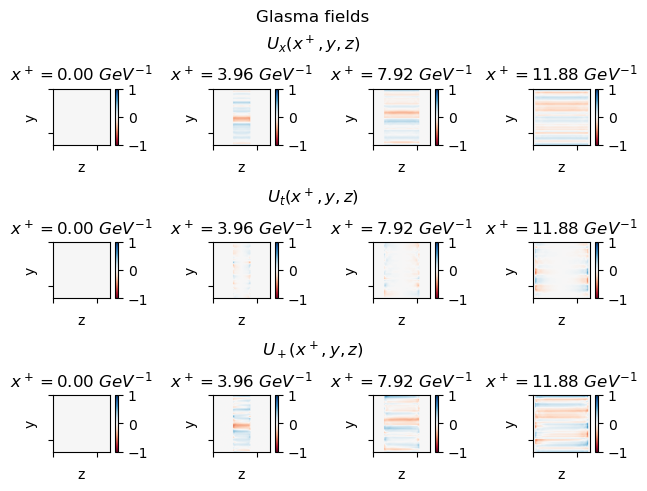

In [ ]:
# We plot the results
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True)
fig.suptitle('Glasma fields')

# We create a subfigure for every row
subfigs = fig.subfigures(nrows=3, ncols=1)
titles = [r'$U_x(x^+, y, z)$', r'$U_t(x^+, y, z)$', r'$U_+(x^+, y, z)$']
for row, subfig in enumerate(subfigs):
    subfig.suptitle(titles[row])
    
    # We create for figures for every row
    axs = subfig.subplots(nrows=1, ncols=4)
    for col, ax in enumerate(axs):
        xplus = 20*col
        
        if row == 0:
            plot = axs[col].imshow(ux_comp[xplus, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1)
        
        if row == 1:
            plot = axs[col].imshow(ut_comp[xplus, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1)
        
        if row ==2:
            plot = axs[col].imshow(up_comp[xplus, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
        
        cbar = plt.colorbar(plot, ax = axs[col])
        axs[col].set_xticklabels([]); axs[col].set_yticklabels([])
        axs[col].set_ylabel('y'); axs[col].set_xlabel('z')
        axs[col].set_title(r'$x^+ = %.2f\ GeV^{-1}$' %(2*a*xplus/hbarc))
    
# plt.savefig('v2_fields/temporal_gauge_fields', bbox_inches='tight')

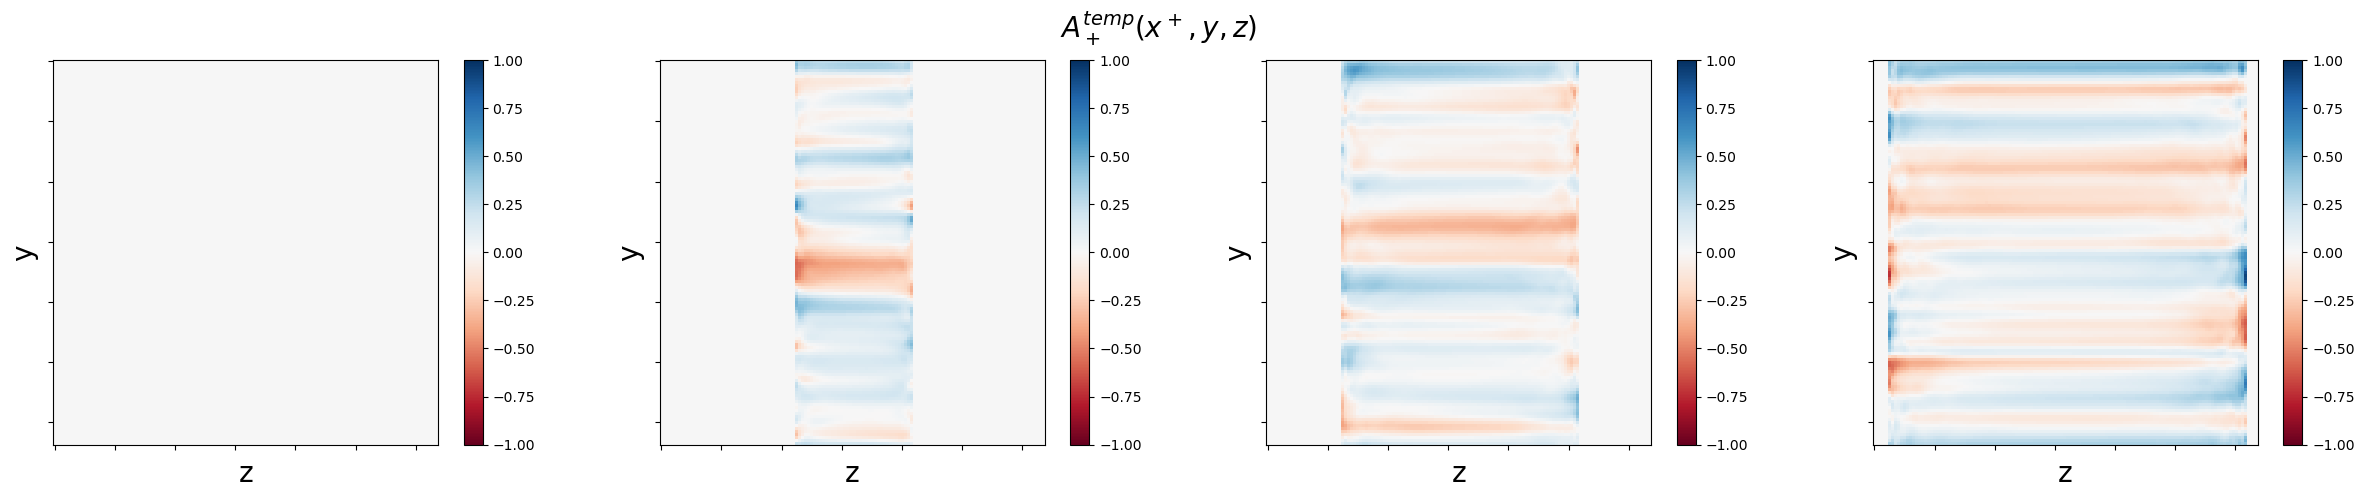

In [7]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$A_+^{temp}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(up_comp[tau, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)

### We transform the $U_+$ links to the LC gauge

We define gain the parameters and the environment

In [3]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2.5         
N = 128
tau_sim = 1.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.68        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.2 * g**2 * mu         
uv = 10.0       


nevents = 1

In [4]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su

Using Numba
Using SU(3)
Using double precision


We define again the simulation routine

In [ ]:
from tqdm import tqdm 

# Simulation routine
def simulate():
    
    # Dictionary to store the results
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N/L*hbarc
    DT = 1.0/DTS 
    maxt = int(tau_sim/a*DTS)
    
    # We create the object Glasma Simulation
    s = core.Simulation(N, DT, g)
    
    # We intialize the Glasma fields
    va = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create objects to store the fields at every time step
    ux_sim = np.zeros((maxt, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    aeta_sim = np.zeros((maxt, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to store U_+ before the gauge transformation
    up = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create objects to store the gauge transformation operator
    vlc0 = np.zeros((N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    vlc1 = np.zeros((N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    vlc_dag = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create objects to store the transformed fields
    up_lc = np.zeros((maxt//DTS-1, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    up_lc_reorder = np.zeros((maxt//DTS-1, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We set them to unit
    for xplus in range(maxt//DTS):
        for y in range(N):
            for z in range(N):
                up[xplus, y, z] = su.unit()
                
    
    # We start the simulation
    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            
            # Evolve the Glasma fields
            core.evolve_leapfrog(s)
            
            # Copy the Glasma fields to our objects
            u1 = s.u1.copy()
            ux_sim[t] = u1[:, 0, :].reshape(N, N, su.GROUP_ELEMENTS)
            
            aeta1 = s.aeta1.copy()
            aeta_sim[t] = aeta1.reshape(N, N, su.GROUP_ELEMENTS)
            
            # When t/a is an integer we transform Ux
            if t%DTS == 0:
                xplus = t//DTS
                
                for y in range(N):
                    for z in range(N):
                        
                        vlc0[y, z] = su.unit(); vlc1[y, z] = su.unit()
                        
                        # We compute the plus links in temporal gauge
                        if -xplus<(z-N/2)<xplus:
                            tau = round(DTS*np.sqrt((xplus)**2-(z-N/2)**2))
                            
                            ux = su.dagger(ux_sim[tau, xplus, y])
                            
                            aeta = su.dagger(aeta_sim[tau, xplus, y])
                            aeta_fact = su.mul_s(aeta, -z/(tau/DTS)**2)
                            ut = su.mexp(aeta_fact)
                            
                            up[xplus, y, z] = su.mul(ut, ux)
                        
                        # We construct the gauge transformation operator
                        for xminus in range(0, 0):
                            if -(xplus+xminus)<(z-N/2)<(xplus+xminus):
                                tau_t = round(DTS*np.sqrt((xplus+xminus)**2-(z-N/2)**2))
                                
                                ux_t = ux_sim[tau_t, xplus-xminus, y]
                                
                                aeta_t = su.dagger(aeta_sim[tau_t, xplus-xminus-1, y])
                                aeta_t_fact = su.mul_s(aeta_t, -z/(tau_t/DTS)**2)
                                ut_t = su.mexp(aeta_t_fact)
                                
                                umin_t = su.mul(ut_t, ux_t)
                                
                                vlc1[y,z] = su.mul(umin_t, vlc0[y, z])
                                
                                vlc0[y, z] = vlc1[y, z]
                                
                        vlc_dag[xplus, y, z] = vlc1[y,z]
                        
                        # We perform the gauge transformation
                        if xplus != 0:
                            aux = su.mul(up[xplus-1, y, z], vlc_dag[xplus-1, y, z])
                            vlc = su.dagger(vlc_dag[xplus, y, z])
                            up_lc[xplus-1, y, z] = su.mul(vlc, aux)
                        
                        # We reorder the fields in a suitable format to input in Meijian's code
                        if z-N/2 >= 0:
                            up_lc_reorder[xplus-1, y, z-N//2] = up_lc[xplus-1, y, z]
                            
                        else:
                            up_lc_reorder[xplus-1, y, N//2+z] = up_lc[xplus-1, y, z]
                        
                            
                            
            pbar.update(1)
            
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    # We reshape the results to input in Meijian's code
    up_lc_out = up_lc_reorder.reshape(maxt//DTS-1, N*N, su.GROUP_ELEMENTS)
        
    # Write the results to the dictionary
    output['up_lc'] = up_lc
    output['up_lc_out'] = up_lc_out
    
    return output

In [14]:
import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    output = simulate()
    up_lc_out = output['up_lc_out']
    up_lc = output['up_lc']
    
    np.save(os.path.join('simulations', 'up_lc', 'result_%i.npy' %n), up_lc_out)

Kernel xi: 0 d:  0 did not reach goal. check:  0.004234237616746659
Kernel xi: 0 d:  1 did not reach goal. check:  0.0013526781969498208
Kernel xi: 1 d:  0 did not reach goal. check:  0.0026839889044288734
Kernel xi: 1 d:  1 did not reach goal. check:  0.00234586813087584
Kernel xi: 2 d:  0 did not reach goal. check:  0.0020134456316218165
Kernel xi: 2 d:  1 did not reach goal. check:  0.002246544347899781
Kernel xi: 3 d:  0 did not reach goal. check:  0.0028873919655712363
Kernel xi: 3 d:  1 did not reach goal. check:  0.0011445568867949824
Kernel xi: 4 d:  0 did not reach goal. check:  0.003949992999922658
Kernel xi: 4 d:  1 did not reach goal. check:  0.00029786971785441114
Kernel xi: 5 d:  0 did not reach goal. check:  0.0033633211015291157
Kernel xi: 5 d:  1 did not reach goal. check:  0.0006378749612855265
Kernel xi: 6 d:  0 did not reach goal. check:  0.0017838491566014602
Kernel xi: 6 d:  1 did not reach goal. check:  0.00044342935806147545
Kernel xi: 7 d:  0 did not reach goal

100%|██████████| 512/512 [01:25<00:00,  6.02it/s]


In [15]:
# Extract the color components

up_lc_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, up_lc)

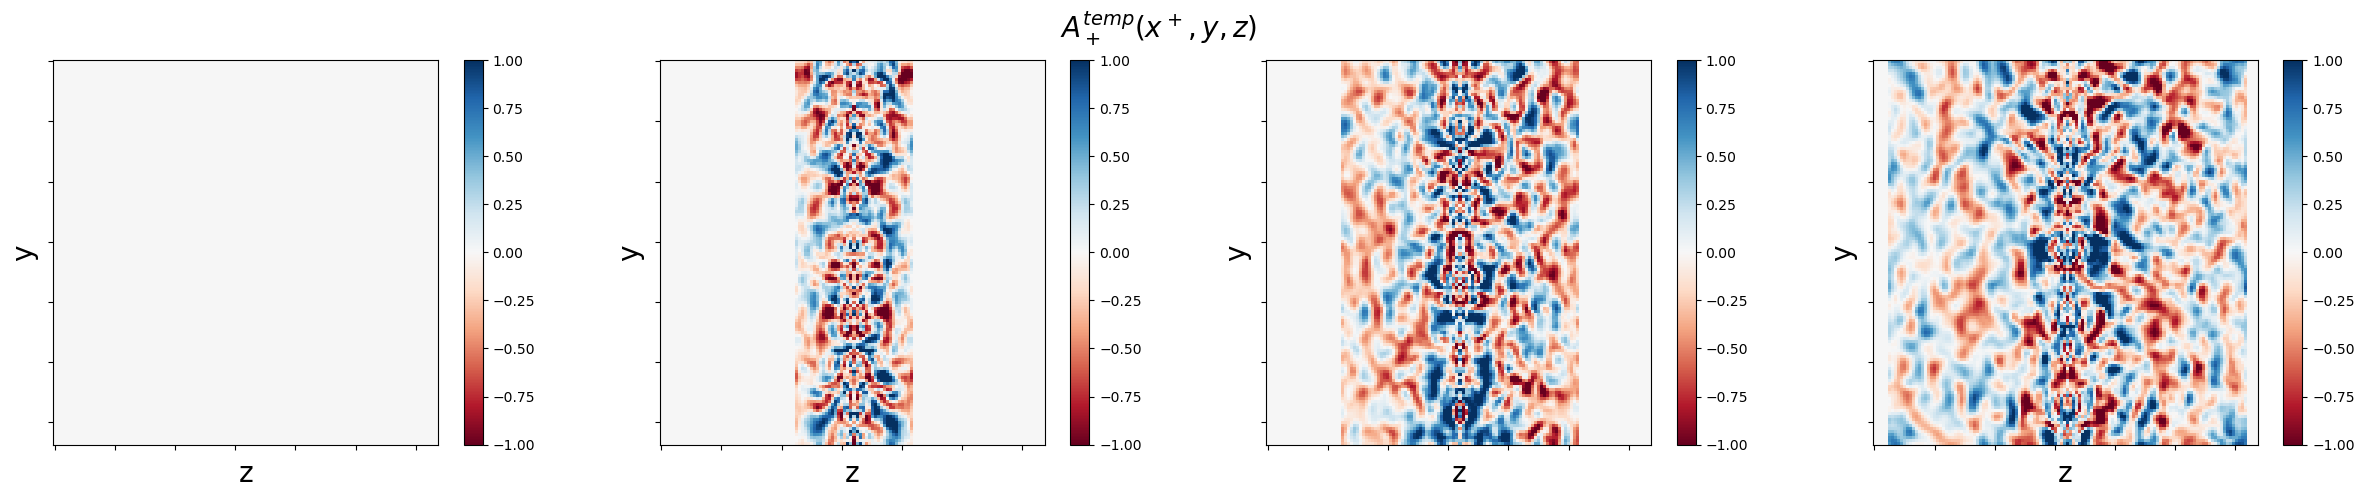

In [16]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$A_+^{temp}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(up_lc_comp[tau, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)

### We transform the $U_-$ links to check the gauge transformation

We define the environment variables

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2.5         
N = 128
tau_sim = 1.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.68        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.2 * g**2 * mu         
uv = 10.0       


nevents = 1

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su

Using Numba
Using SU(3)
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We define the simulation routine

In [3]:
from tqdm import tqdm 

# Simulation routine
def simulate():
    
    # Dictionary to store the results
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N/L*hbarc
    DT = 1.0/DTS 
    maxt = int(tau_sim/a*DTS)
    
    # We create the object Glasma Simulation
    s = core.Simulation(N, DT, g)
    
    # We intialize the Glasma fields
    va = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create objects to store the fields at every time step
    ux_sim = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    aeta_sim = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to store U_+ before the gauge transformation
    up = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create objects to store the gauge transformation operator
    vlc0 = np.zeros((N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    vlc1 = np.zeros((N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    vlc_dag = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    vlc = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create objects to store the transformed fields
    up_lc = np.zeros((maxt//DTS-1, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    up_lc_reorder = np.zeros((maxt//DTS-1, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We set them to unit
    for xplus in range(maxt//DTS):
        for y in range(N):
            for z in range(N):
                up[xplus, y, z] = su.unit()
                
                vlc0[y, z] = su.unit()
                vlc1[y, z] = su.unit()
                
    
    # We start the simulation
    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            
            # Evolve the Glasma fields
            core.evolve_leapfrog(s)
            
            # When t/a is an integer we transform Ux
            if t%DTS == 0:
                xplus = t//DTS
                
                # Copy the Glasma fields to our objects
                u1 = s.u1.copy()
                ux_sim[xplus] = u1[:, 0, :].reshape(N, N, su.GROUP_ELEMENTS)
            
                aeta1 = s.aeta1.copy()
                aeta_sim[xplus] = aeta1.reshape(N, N, su.GROUP_ELEMENTS)
                
                for y in range(N):
                    for z in range(N):
                        
                        # We compute the minus links in temporal gauge
                        if -xplus<(z-N/2)<xplus:
                            tau = round(np.sqrt((xplus)**2-(z-N/2)**2))
                            
                            ux = ux_sim[tau, xplus, y]
                            
                            aeta = su.dagger(aeta_sim[tau, xplus, y])
                            aeta_fact = su.mul_s(aeta, -z/tau**2)
                            ut = su.mexp(aeta_fact)
                            
                            up[xplus, y, z] = su.mul(ut, ux)
                        
                        # We construct the gauge transformation operator
                        for xminus in range(-xplus, 1):
                            if -(xplus+xminus)<(z-N/2)<(xplus+xminus):
                                tau_t = round(np.sqrt((xplus+xminus)**2-(z-N/2)**2))
                                
                                ux_t = ux_sim[tau_t, xplus-xminus, y]
                                
                                aeta_t = su.dagger(aeta_sim[tau_t, xplus-xminus, y])
                                aeta_t_fact = su.mul_s(aeta_t, -z/tau_t**2)
                                ut_t = su.mexp(aeta_t_fact)
                                
                                umin_t = su.mul(ut_t, ux_t)
                                
                                vlc1[y,z] = su.mul(umin_t, vlc0[y, z])
                                
                                vlc0[y, z] = vlc1[y, z]
                                
                            if xminus == -1:
                                vlc_dag[xplus, y, z] = vlc1[y,z]
                            elif xminus == 0:
                                vlc[xplus, y, z] = su.dagger(vlc1[y, z])
                        
                        # We perform the gauge transformation
                        if xplus != 0:
                            aux = su.mul(up[xplus-1, y, z], vlc_dag[xplus-1, y, z])
                            up_lc[xplus-1, y, z] = su.mul(vlc[xplus-1, y, z], aux)
                        
                        # We reorder the fields in a suitable format to input in Meijian's code
                        if z-N/2 >= 0:
                            up_lc_reorder[xplus-1, y, z-N//2] = up_lc[xplus-1, y, z]
                            
                        else:
                            up_lc_reorder[xplus-1, y, N//2+z] = up_lc[xplus-1, y, z]
                        
                            
                            
            pbar.update(1)
            
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    # We reshape the results to input in Meijian's code
    up_lc_out = up_lc_reorder.reshape(maxt//DTS-1, N*N, su.GROUP_ELEMENTS)
        
    # Write the results to the dictionary
    output['up_lc'] = up_lc
    output['up_lc_out'] = up_lc_out
    
    return output

In [4]:
import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    output = simulate()
    up_lc_out = output['up_lc_out']
    up_lc = output['up_lc']

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Kernel xi: 0 d:  0 did not reach goal. check:  0.0008910501516899191
Kernel xi: 0 d:  1 did not reach goal. check:  0.0034485265951877584
Kernel xi: 1 d:  0 did not reach goal. check:  0.0007366241012151348
Kernel xi: 1 d:  1 did not reach goal. check:  0.0036744176412108974
Kernel xi: 2 d:  0 did not reach goal. check:  0.0004938258846261421
Kernel xi: 2 d:  1 did not reach goal. check:  0.0029926695613940063
Kernel xi: 3 d:  0 did not reach goal. check:  0.0005255309745345101
Kernel xi: 3 d:  1 did not reach goal. check:  0.0016375166668058736
Kernel xi: 4 d:  0 did not reach goal. check:  0.0010471299690975155
Kernel xi: 4 d:  1 did not reach goal. check:  0.0018080865710156813
Kernel xi: 5 d:  0 did not reach goal. check:  0.002701884869058741
Kernel xi: 5 d:  1 did not reach goal. check:  0.0021475454098313957
Kernel xi: 6 d:  0 did not reach goal. check:  0.005132516749142975
Kernel xi: 6 d:  1 did not reach goal. check:  0.0020102755853011163
Kernel xi: 7 d:  0 did not reach goa

100%|██████████| 512/512 [01:25<00:00,  5.97it/s]


We plot the results

In [5]:
# Extract the color components

up_lc_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, up_lc)

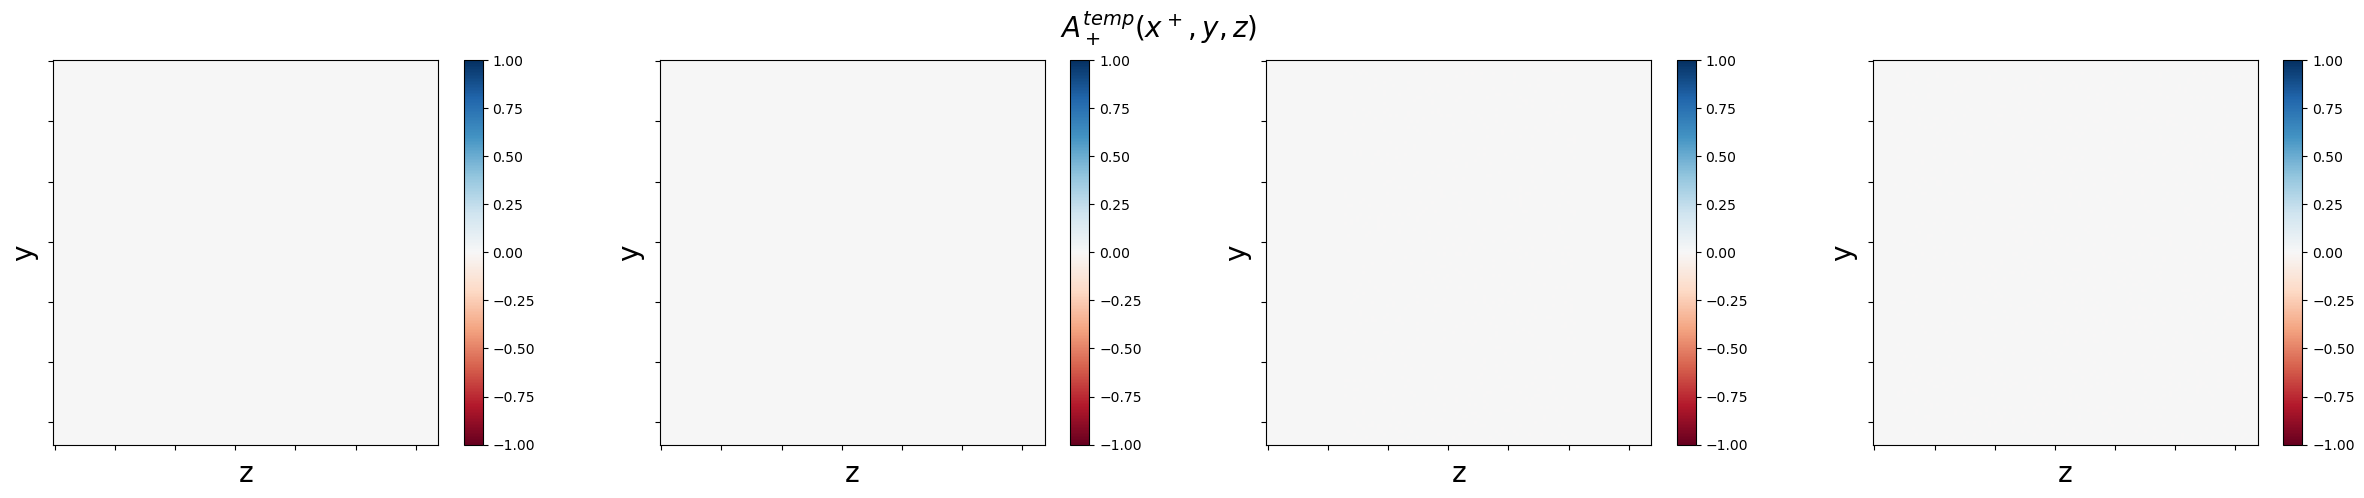

In [16]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$A_+^{temp}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(up_lc_comp[tau, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)